In [21]:
# Imports from the helpers folder, containing the lstm code and auxilliary functions
import sys  
sys.path.insert(0, "helpers/")
from lstm import Model, Optimization
from aux_functions import (dateindex_from_weeknum, dateindex_from_timestamp, ts_train_test_split, 
                           cols_with_most_corr, lagged_corr, lagged_corr_matrix, 
                           cols_with_most_lagged_corr, calculate_pvalues, cols_with_sig_pval, corr_feature_selection)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pltio
import statsmodels.api as sm
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
# Packages of forecasting models
from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive, drift, mean, seasonal_naive)
import pmdarima as pm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Load data

In [2]:
# Milan daily sales data
milan_data_df = pd.read_csv("../datasets/milan_daily.csv", index_col=[0], parse_dates=True)
# Turin daily sales data
turin_data_df = pd.read_csv("../datasets/turin_daily.csv", index_col=[0], parse_dates=True)
# Rome daily sales data
rome_data_df = pd.read_csv("../datasets/rome_daily.csv", index_col=[0], parse_dates=True)

print("Milan sales data:", milan_data_df.shape)
print(milan_data_df.head())
print("\n")
print("Turin sales data:", turin_data_df.shape)
print(turin_data_df.head())
print("\n")
print("Rome sales data:", rome_data_df.shape)
print(rome_data_df.head())
print("\n\n")

## Exogenous weather data
milan_weather_df = pd.read_csv("../datasets/Eso_data/weather/milano_weather_data.csv")
turin_weather_df = pd.read_csv("../datasets/Eso_data/weather/torino_weather_data.csv")
rome_weather_df = pd.read_csv("../datasets/Eso_data/weather/roma_weather_data.csv")

Milan sales data: (277702, 3)
            qty codice esterno tab negozio
time                                      
2016-04-14    1  PA312119NE-16       ARESE
2016-04-14    1       S39FA-16       ARESE
2016-04-14    1     ME138BL-16       ARESE
2016-04-14    1      C3FABL-16       ARESE
2016-04-14    1  LI240521BI-16       ARESE


Turin sales data: (371732, 3)
            qty   codice esterno tab negozio
time                                        
2016-01-02    1  LDVF5253FANE-15       TORIN
2016-01-02    1    LDVF5264FA-15        JUVE
2016-01-02    1  LDVF5206FANE-15        JUVE
2016-01-02    1    LDVF5237NE-15       TORIN
2016-01-02    1        GG43FA-16        JUVE


Rome sales data: (296486, 3)
            qty       codice esterno tab negozio
time                                            
2016-01-02    1  VA713346T15128FA-15       TUSC1
2016-01-02    1       MA3243905FA-15       TIBUR
2016-01-02    1        LDVF5233FA-15       TUSC1
2016-01-02    1            SS62FA-15       TUS

In [3]:
def augment_store_data (store_df, loc_weather_df):
    ## STORE DATA
    # Drop store column, we won't be using those
    store_df = store_df.drop(["tab negozio", "codice esterno"], axis=1)

    # Aggregate the data to get the total sales of each week
    store_daily_totals = store_df.groupby(pd.Grouper(freq = "D")).agg({
        "qty": np.sum
    })

    # Check for NAN values in sales and replace them if they are present
    sales_nan_indices = store_daily_totals[store_daily_totals.isnull().any(axis=1)].index
    for nan_idx in sales_nan_indices:
        n_days_ago = nan_idx - timedelta(days=1)
        store_daily_totals.loc[nan_idx, "qty"] = np.mean(store_daily_totals.loc[n_days_ago:nan_idx,"qty"].values)
    
    day_nr = np.array(list(map(int, store_daily_totals.index.strftime('%j').tolist())))
    store_daily_totals["sin_day"] =  np.sin((day_nr/365) * 2*np.pi)
    store_daily_totals["cos_day"] = np.cos((day_nr/365) * 2*np.pi)
    store_daily_totals["sincos_day"] = np.sin((day_nr/365) * 2*np.pi) * np.cos((day_nr/365) * 2*np.pi)
    
    ## WEATHER DATA
    # Converting the index as datetime index
    loc_weather_df = loc_weather_df.set_index(["DATA"])
    loc_weather_df.index = pd.to_datetime(loc_weather_df.index) # make ts

    # We won't be using the following cols (nan vals or categorical)
    loc_weather_df = loc_weather_df.drop(["LOCALITA", "FENOMENI", "PIOGGIA mm", "PRESSIONEMEDIA mb"], axis=1)
    
    # Check for NAN values in sales and replace them if they are present
    weather_nan_indices = loc_weather_df[loc_weather_df.isnull().any(axis=1)].index
    for nan_idx in weather_nan_indices:
        for col in loc_weather_df:
            n_days_after = nan_idx + timedelta(days=2)
            loc_weather_df.loc[nan_idx, col] = np.mean(loc_weather_df.loc[nan_idx:n_days_after, col])
    
    # Here we add exogenous data we run the train the network with and without these new data. 
    # If the prediction improves then we are looking at leading indicator and better forecast accuracy.
    store_daily_weather_augmented = store_daily_totals.copy(deep=True)
    for w_col in loc_weather_df.columns:
        store_daily_weather_augmented[w_col] = loc_weather_df.loc[:, w_col]
   
    
    return store_daily_totals, store_daily_weather_augmented

# Augment single location sales data and then put everything together
milan_daily_default, milan_daily_augmented = augment_store_data(milan_data_df, milan_weather_df)
print("Milan data original shape:", milan_daily_default.shape)
print("Milan + exogenous data shape:", milan_daily_augmented.shape)
turin_daily_default, turin_daily_augmented = augment_store_data(turin_data_df, turin_weather_df)
print("Turin data original shape:", turin_daily_default.shape)
print("Turin + exogenous data shape:", turin_daily_augmented.shape)
rome_daily_default, rome_daily_augmented = augment_store_data(rome_data_df, rome_weather_df)
print("Rome data original shape:", rome_daily_default.shape)
print("Rome + exogenous data shape:", rome_daily_augmented.shape)

Milan data original shape: (1357, 4)
Milan + exogenous data shape: (1357, 14)
Turin data original shape: (1460, 4)
Turin + exogenous data shape: (1460, 14)
Rome data original shape: (1460, 4)
Rome + exogenous data shape: (1460, 14)


In [81]:
## Create dicts for different store data
def_datasets = {
    "Milan": milan_daily_default,
    #"Turin": turin_daily_default,
    #"Rome": rome_daily_default
}
aug_datasets = {
    "Milan": milan_daily_augmented,
    #"Turin": turin_daily_augmented, 
    #"Rome": rome_daily_augmented
}

# Data Visualization and Exploration 

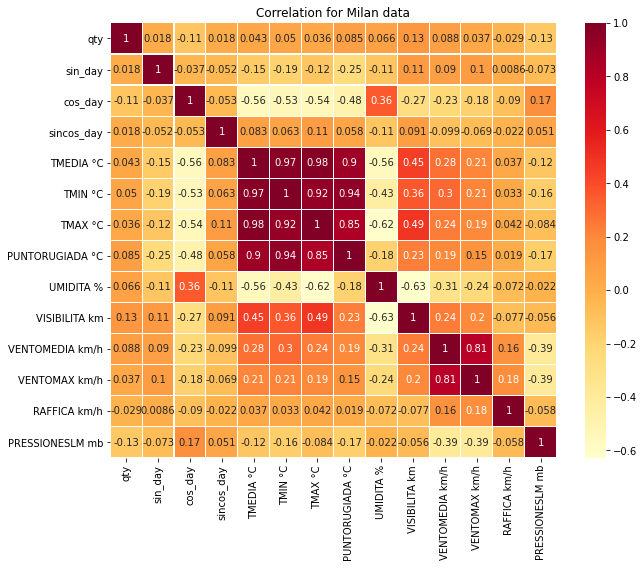

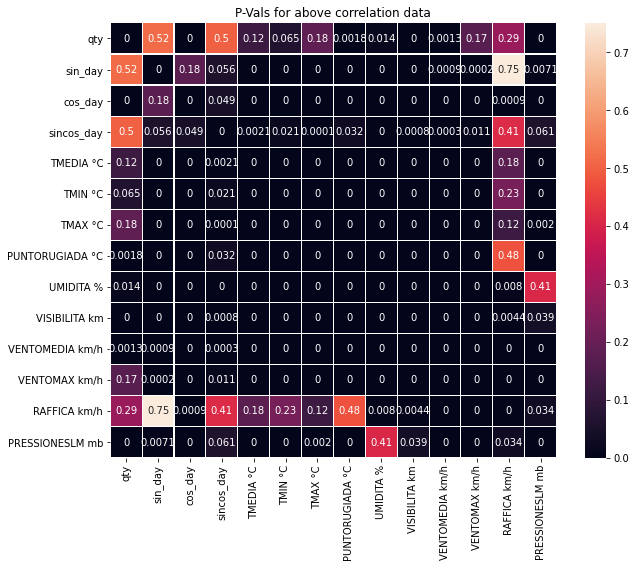

Features with a statistically coefficient are: [0, 2, 7, 8, 9, 10, 13]


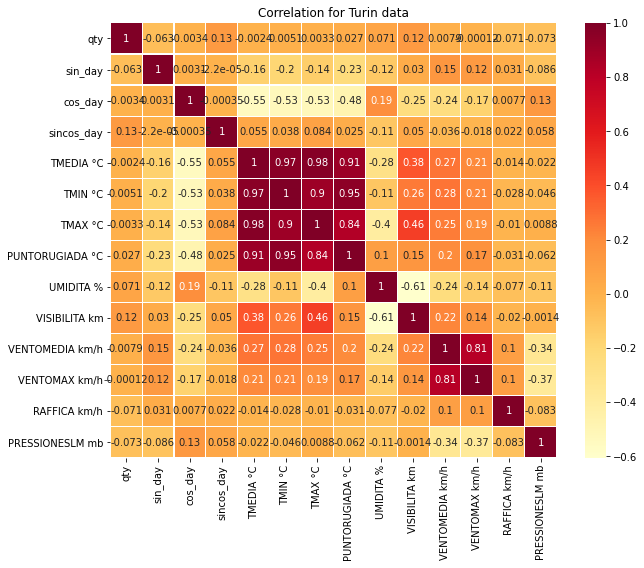

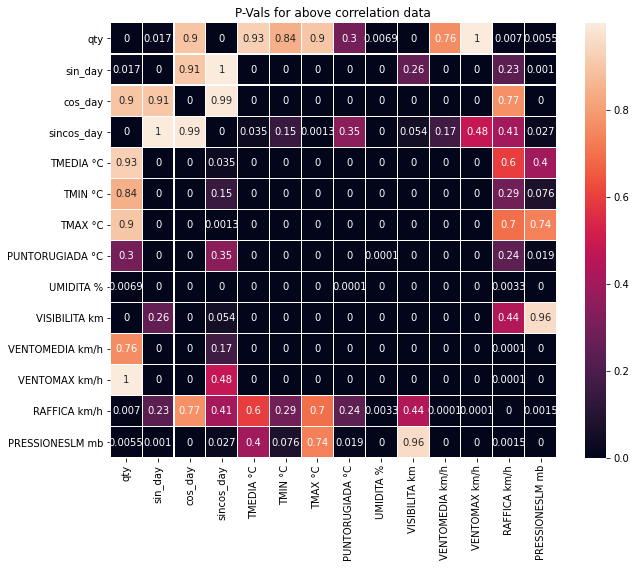

Features with a statistically coefficient are: [0, 1, 3, 8, 9, 13]


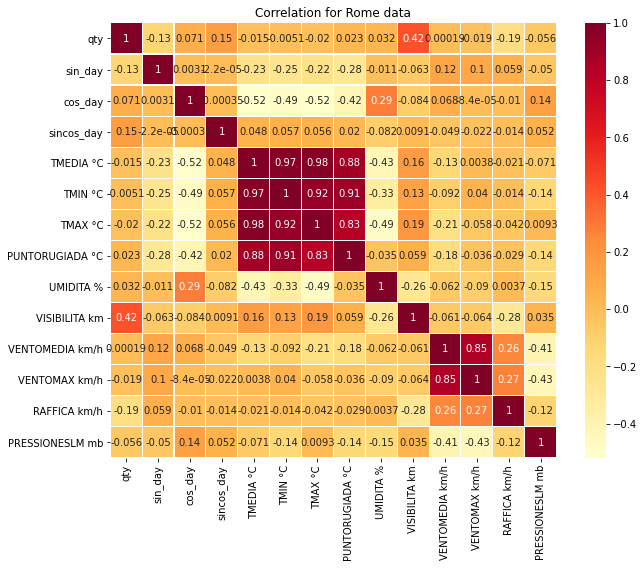

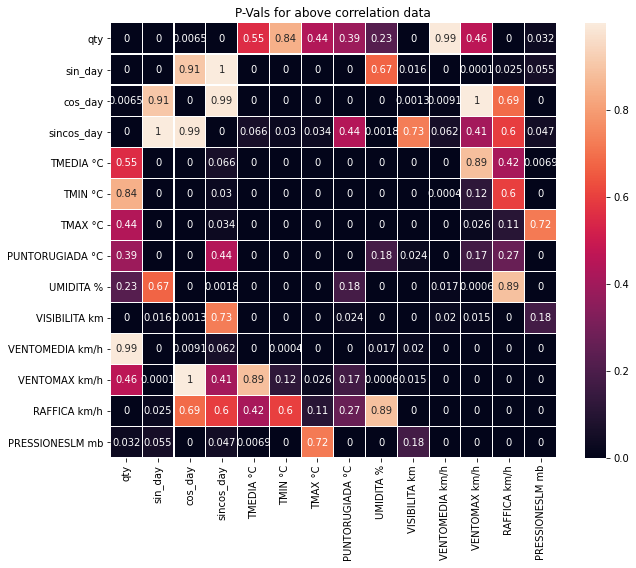

Features with a statistically coefficient are: [0, 1, 2, 3, 9, 13]


In [7]:
# Correlation in the data with added exogenous variables: Spearman Correlation
for dataset in aug_datasets:    
    default_s_corr = aug_datasets[dataset].corr(method="spearman")
    plt.figure(figsize=(10,8))
    sns.heatmap(data=default_s_corr, cmap="YlOrRd", annot=True, linewidths=.1)
    plt.title("Correlation for "+ dataset+" data")
    plt.show()

    def_p_val_matrix = calculate_pvalues(aug_datasets[dataset], lag=0)
    plt.figure(figsize=(10,8))
    sns.heatmap(data=def_p_val_matrix, annot=True, linewidths=.1)
    plt.title("P-Vals for above correlation data")
    plt.show()
    
    exo_features = cols_with_sig_pval(aug_datasets[dataset])
    print("Features with a statistically coefficient are:", exo_features)
   
   #lagged_s_corr = lagged_corr_matrix(milan_weekly_augmented, lag=1)
   #plt.figure(figsize=(10,8))
   #sns.heatmap(data=lagged_s_corr, cmap="YlOrRd", annot=True, linewidths=.1)
   #plt.title("Lagged correlation for "+ dataset + " data")
   #plt.show()
   #
   #lagged_p_val_matrix = calculate_pvalues(aug_datasets[dataset], lag=1)
   #plt.figure(figsize=(10,8))
   #sns.heatmap(data=lagged_p_val_matrix, annot=True, linewidths=.1)
   #plt.title("P-Vals for above correlation data")
   #plt.show()

Milan data 



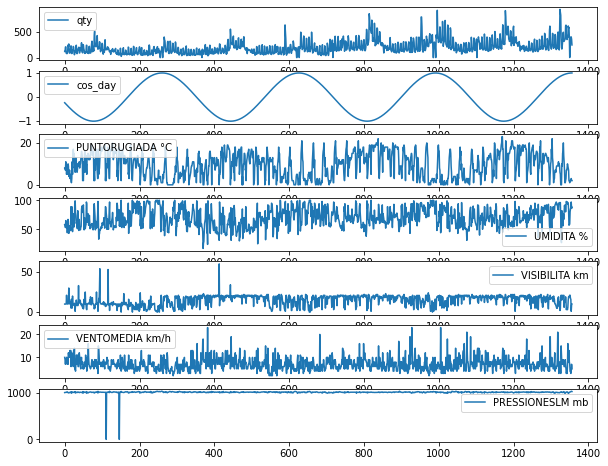

Turin data 



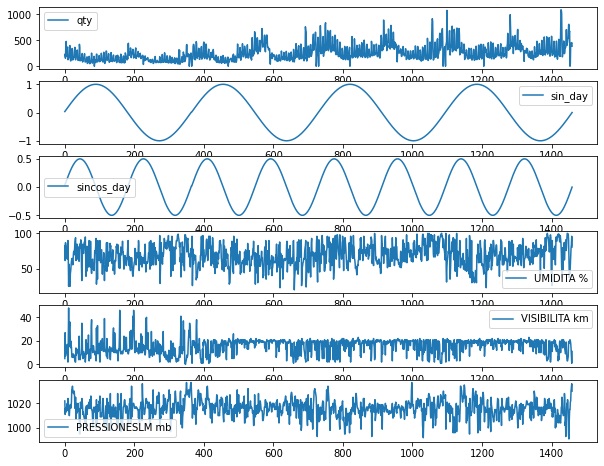

Rome data 



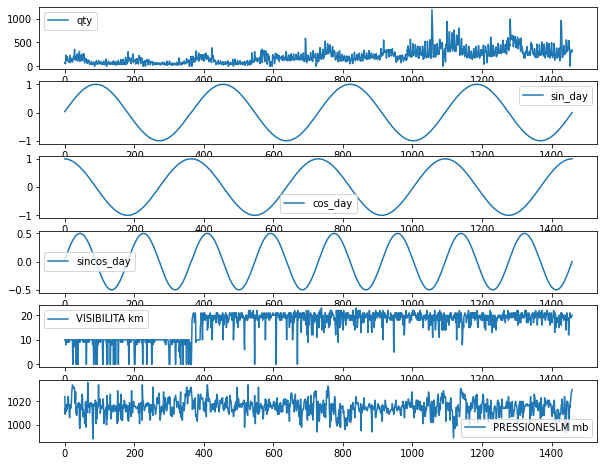

In [8]:
# Plot the data to explore and see what we are working with
for dataset in aug_datasets:
    print(dataset, "data \n")
    # Plot the data with the most correlation to the sales we are trying to predict
    # These are the features we will train the network on later
    values = aug_datasets[dataset].values
    cols_to_plot = cols_with_sig_pval(aug_datasets[dataset])
 
    i=1
    plt.figure(figsize=(10,8))
    for col in cols_to_plot:
        plt.subplot(len(cols_to_plot), 1, i)
        plt.plot(values[:, col], label=aug_datasets[dataset].columns[col])
        plt.legend()
        i += 1
    plt.show()

# LSTM helper functions

In [69]:
def build_in_out_seq(tr_df, te_df, desired_input_features, in_len, out_len):
    # Building the NN input and outputs. LSTM will expect a supervised learning problem, hence we need to build
    # input sequences that will have output sequences which the model will then learn.
    
    # Training
    inp_tr = np.stack([tr_df.shift(i).values for i in range(out_len, out_len+in_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    out_tr = np.stack([tr_df.shift(i).values for i in range(out_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    # Testing
    inp_te = np.stack([te_df.shift(i).values for i in range(out_len, out_len+in_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    out_te = np.stack([te_df.shift(i).values for i in range(out_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    print("Inputs for training")
    print(inp_tr.shape)
    print("Outputs for training")
    print(out_tr.shape)
    print("Inputs for testing")
    print(inp_te.shape)
    print("Outputs for testing")
    print(out_te.shape)
    print("\n")

    return inp_tr, out_tr, inp_te, out_te

In [71]:
def prepare_for_network(train, test, input_features, in_len, out_len):
    # Build the full training and testing dataframes
    # In order to pass the data to the LSTM we need to transform it so it is in the range [0,1]
    # We scale all our data in order to build the final training and test dataframes
    tr_df = train.copy(deep=True)
    te_df = test.copy(deep=True)
    
    for col in tr_df.columns:
        # Z standartization
        mean = np.mean(train.loc[:,col].values)
        std = np.std(train.loc[:,col].values)
        
        tr_df.loc[:, col] = (train.loc[:,col].values-mean)/std
        te_df.loc[:, col] = (test.loc[:,col].values-mean)/std


    inp_tr, out_tr, inp_te, out_te = build_in_out_seq(tr_df, pd.concat([tr_df.iloc[-in_len:, :], te_df]), input_features, in_len, out_len)
    return inp_tr, out_tr, inp_te, out_te

In [40]:
def define_LSTM_Model(input_features):
    loss_fn = nn.MSELoss()
    LSTM_Model = Model(input_size=len(input_features), hidden_size=20 + len(input_features)*5, output_size=len(input_features))
    optimizer = optim.Adam(LSTM_Model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=25, gamma=0.1)
    opt_obj = Optimization(LSTM_Model, loss_fn, optimizer, scheduler)
    return LSTM_Model, opt_obj

In [41]:
def check_lstm_forecast_results(pred, inp_te, out_te, poll_mean, poll_std, in_len, out_len):
    # *Data back needs to rescaled back to normal*
    pred_vec = (pred[0,-out_len:,0].detach().cpu().numpy() * poll_std) + poll_mean
    real_vec = (out_te[0,:,0] * poll_std) + poll_mean
    rmse = sm.tools.eval_measures.rmse(pred_vec, real_vec)
    mae = sm.tools.eval_measures.meanabs(pred_vec, real_vec)
    
    return rmse, mae

# Forecasting evaluation

In [83]:
single_run_results = []
n_runs = 3

for dataset in aug_datasets:
    print("Running forecasting for sales in", dataset)
    #lstm_def_rmse = curr_def_mae = curr_aug_rmse = curr_aug_mae = 0
    for run in range(n_runs):
        print ("Run #", run+1)
        # Load the default and augmented versions of the data
        aug_dataset = aug_datasets[dataset]
        def_dataset = def_datasets[dataset]

        # Create training and test data
        def_train, def_test = ts_train_test_split(def_dataset, test_length=0.1)
        aug_train, aug_test = ts_train_test_split(aug_dataset, test_length=0.1)
        print(def_train.shape, def_test.shape, aug_train.shape, aug_test.shape)

        # Extract the columns which display most correlation with the value we are trying to predict.
        def_desired_input_features = corr_feature_selection(def_train)
        aug_desired_input_features = corr_feature_selection(aug_train)
        all_poss_features = list(range(0, len(aug_train.columns)))
        print("Default input features:", def_desired_input_features)
        print("Input features with selected exogenous data:", aug_desired_input_features)
        print("Input features with all exogenous data:", all_poss_features)
        print()
        
        # Run STL Decomposition as baseline
        print("Running Drift model based on STL Decomposition...")
        f_steps = def_test.shape[0]
        decomp = decompose(def_train.qty, period=52)
        drift_forecast = forecast(decomp, steps=f_steps, fc_func=drift)
        drift_rmse = sm.tools.eval_measures.rmse(def_test.qty.values, drift_forecast["drift"].values)
        drift_mae = sm.tools.eval_measures.meanabs(def_test.qty.values, drift_forecast["drift"].values)
        print("Done\n")
        
        # Run ARIMA as another baseline
        print("Running ARIMA model...")
        # Fit your model
        arima_model = pm.auto_arima(def_train.qty, suppress_warnings=True, max_order=None, \
                                    start_p=3, start_q=0, start_P=0, start_Q=0, \
                                    max_p=6, max_d=1, max_q=1, max_P=1, max_D=1, max_Q=1)
        arima_order = arima_model.get_params()["order"]
        arima_fitted = arima_model.fit(def_train.qty)
        arima_forecasts = arima_fitted.predict(f_steps)  
        arima_rmse = sm.tools.eval_measures.rmse(def_test.qty.values, arima_forecasts)
        arima_mae = sm.tools.eval_measures.meanabs(def_test.qty.values, arima_forecasts)
        print("Done\n")
        
        # Run ARIMAX as another baseline
        print("Running ARIMAX model...")
        arimax_fitted = arima_model.fit(y=aug_train.qty, exogenous=aug_train.iloc[:, aug_desired_input_features[1:]])
        arimax_forecasts = arimax_fitted.predict(f_steps, exogenous=aug_test.iloc[:, aug_desired_input_features[1:]])  
        arimax_rmse = sm.tools.eval_measures.rmse(def_test.qty.values, arimax_forecasts)
        arimax_mae = sm.tools.eval_measures.meanabs(def_test.qty.values, arimax_forecasts)
        print("Done\n")
        
        
        # LSTM and EXO-LSTM
        # Prepare data for the LSTM Network: We need to create sequences of inputs and outputs
        # so that our time series problem esentially becomes a "supervised regression problem".
        # The inputs are also normalized between 0 and 1 before being fed to the network
        def_inp_tr, def_out_tr, def_inp_te, def_out_te = prepare_for_network(def_train, def_test, def_desired_input_features, in_len=200, out_len=f_steps)
        aug_inp_tr, aug_out_tr, aug_inp_te, aug_out_te = prepare_for_network(aug_train, aug_test, aug_desired_input_features, in_len=200, out_len=f_steps)
        all_aug_inp_tr, all_aug_out_tr, all_aug_inp_te, all_aug_out_te = prepare_for_network(aug_train, aug_test, all_poss_features, in_len=200, out_len=f_steps)

        # Transform the input and output sequences into PyTorch Tensors in order to feed them to the model
        def_x_train=torch.cat((torch.Tensor(def_inp_tr),torch.Tensor(def_out_tr)),1)
        def_x_test=torch.Tensor(def_inp_te)
        aug_x_train=torch.cat((torch.Tensor(aug_inp_tr),torch.Tensor(aug_out_tr)),1)
        aug_x_test=torch.Tensor(aug_inp_te)
        all_aug_x_train=torch.cat((torch.Tensor(all_aug_inp_tr),torch.Tensor(all_aug_out_tr)),1)
        all_aug_x_test=torch.Tensor(all_aug_inp_te)
        
        # Define the two LSTM Models and Optimizer objects (one for Vanilla and the other for EXO)
        loss_fn = nn.MSELoss()

        def_LSTM_Model, def_opt_obj = define_LSTM_Model(def_desired_input_features)
        exo_LSTM_Model, exo_opt_obj = define_LSTM_Model(aug_desired_input_features)
        all_exo_LSTM_Model, all_exo_opt_obj = define_LSTM_Model(all_poss_features)         

        
        print("Training the default LSTM model...")#15+len(aug_desired_input_features)*2
        def_opt_obj.train(def_x_train[:,:-1],def_x_train[:,1:],def_x_train[:,:-1],def_x_train[:,1:], do_teacher_forcing=True, n_epochs=10+len(def_desired_input_features)*2)
        print("Done\n")
        print("Training the augmented EXO-LSTM model...")
        exo_opt_obj.train(aug_x_train[:,:-1],aug_x_train[:,1:],aug_x_train[:,:-1],aug_x_train[:,1:], do_teacher_forcing=True, n_epochs=10+len(aug_desired_input_features)*2)
        print("Done\n")
        print("Training the augmented EXO-LSTM model...")
        all_exo_opt_obj.train(all_aug_x_train[:,:-1],all_aug_x_train[:,1:],all_aug_x_train[:,:-1],all_aug_x_train[:,1:], do_teacher_forcing=True, n_epochs=10+len(aug_desired_input_features)*2)
        print("Done\n")

        def_pred = def_LSTM_Model(def_x_test, f_steps)
        def_pred_vector = def_pred[0,:,0].detach().cpu().numpy()
        aug_pred = exo_LSTM_Model(aug_x_test, f_steps)
        aug_pred_vector = aug_pred[0,:,0].detach().cpu().numpy()
        all_aug_pred = all_exo_LSTM_Model(all_aug_x_test, f_steps)
        all_aug_pred_vector = all_aug_pred[0,:,0].detach().cpu().numpy()

        # Check results of LSTM forecasts
        mean = np.mean(def_train.qty.values)
        std = np.std(def_train.qty.values)
        lstm_def_rmse, lstm_def_mae = check_lstm_forecast_results(def_pred, def_inp_te, def_out_te, mean, std, in_len=200, out_len=f_steps)
        lstm_aug_rmse, lstm_aug_mae = check_lstm_forecast_results(aug_pred, aug_inp_te, aug_out_te, mean, std, in_len=200, out_len=f_steps)
        lstm_all_aug_rmse, lstm_all_aug_mae = check_lstm_forecast_results(all_aug_pred, aug_inp_te, aug_out_te, mean, std, in_len=200, out_len=f_steps)

        fig = go.Figure()
        x_labels = list(range(0,f_steps))
        fig.add_trace(go.Scatter(x=x_labels, y=def_test.qty,
                    mode='lines', name='GT'))
        fig.add_trace(go.Scatter(x=x_labels, y=drift_forecast["drift"].values,
                    mode='lines', name='Drift'))
        fig.add_trace(go.Scatter(x=x_labels, y=arima_forecasts,
                    mode='lines', name='ARIMA'+str(arima_order)))
        fig.add_trace(go.Scatter(x=x_labels, y=arimax_forecasts,
                    mode='lines', name='ARIMAX'+str(arima_order)))
        fig.add_trace(go.Scatter(x=x_labels, y=(def_pred_vector*std)+mean,
                    mode='lines', name='LSTM'))
        fig.add_trace(go.Scatter(x=x_labels, y=(aug_pred_vector*std)+mean,
                    mode='lines', name='EXO-LSTM'))
        fig.add_trace(go.Scatter(x=x_labels, y=(all_aug_pred_vector*std)+mean,
                    mode='lines', name='ALL-EXO-LSTM'))
        #Update plot title and axis titles, then save plot as a HTML File
        fig.update_layout(
            title="Forecast of test set",
            xaxis_title="Time steps",
            yaxis_title="Prediction",
            font=dict(
                family="Courier New, monospace",
                size=16,
                color="#7f7f7f"
            )
        )
        fig.show()
        #pltio.write_html(fig, dataset+"-"+"run"+str(run+1)+"daily-sales-results.html")
        single_run_results.append([dataset, "run "+str(run+1), drift_rmse, arima_rmse, arimax_rmse, lstm_def_rmse, \
                                   lstm_aug_rmse, lstm_all_aug_rmse, drift_mae, arima_mae, arimax_mae, \
                                   lstm_def_mae, lstm_aug_mae, lstm_all_aug_mae])
        print()

Running forecasting for sales in Milan
Run # 1
(1222, 4) (135, 4) (1222, 14) (135, 14)
Default input features: [0, 2]
Input features with selected exogenous data: [0, 2, 7, 9, 13]
Input features with all exogenous data: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

Running Drift model based on STL Decomposition...
Done

Running ARIMA model...
Done

Running ARIMAX model...
Done

Inputs for training
(888, 200, 2)
Outputs for training
(888, 135, 2)
Inputs for testing
(1, 200, 2)
Outputs for testing
(1, 135, 2)


Inputs for training
(888, 200, 5)
Outputs for training
(888, 135, 5)
Inputs for testing
(1, 200, 5)
Outputs for testing
(1, 135, 5)


Inputs for training
(888, 200, 14)
Outputs for training
(888, 135, 14)
Inputs for testing
(1, 200, 14)
Outputs for testing
(1, 135, 14)


Training the default LSTM model...
Epoch 1 Train loss: 0.73. Validation loss: 0.48. Avg future: 84.18. Elapsed time: 15.76s.
Epoch 2 Train loss: 0.40. Validation loss: 0.37. Avg future: 92.86. Elapsed time: 15.7


Run # 2
(1222, 4) (135, 4) (1222, 14) (135, 14)
Default input features: [0, 2]
Input features with selected exogenous data: [0, 2, 7, 9, 13]
Input features with all exogenous data: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

Running Drift model based on STL Decomposition...
Done

Running ARIMA model...
Done

Running ARIMAX model...
Done

Inputs for training
(888, 200, 2)
Outputs for training
(888, 135, 2)
Inputs for testing
(1, 200, 2)
Outputs for testing
(1, 135, 2)


Inputs for training
(888, 200, 5)
Outputs for training
(888, 135, 5)
Inputs for testing
(1, 200, 5)
Outputs for testing
(1, 135, 5)


Inputs for training
(888, 200, 14)
Outputs for training
(888, 135, 14)
Inputs for testing
(1, 200, 14)
Outputs for testing
(1, 135, 14)


Training the default LSTM model...
Epoch 1 Train loss: 0.67. Validation loss: 0.44. Avg future: 81.10. Elapsed time: 14.04s.
Epoch 2 Train loss: 0.39. Validation loss: 0.35. Avg future: 81.90. Elapsed time: 14.23s.
Epoch 3 Train loss: 0.32. Validati


Run # 3
(1222, 4) (135, 4) (1222, 14) (135, 14)
Default input features: [0, 2]
Input features with selected exogenous data: [0, 2, 7, 9, 13]
Input features with all exogenous data: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

Running Drift model based on STL Decomposition...
Done

Running ARIMA model...
Done

Running ARIMAX model...
Done

Inputs for training
(888, 200, 2)
Outputs for training
(888, 135, 2)
Inputs for testing
(1, 200, 2)
Outputs for testing
(1, 135, 2)


Inputs for training
(888, 200, 5)
Outputs for training
(888, 135, 5)
Inputs for testing
(1, 200, 5)
Outputs for testing
(1, 135, 5)


Inputs for training
(888, 200, 14)
Outputs for training
(888, 135, 14)
Inputs for testing
(1, 200, 14)
Outputs for testing
(1, 135, 14)


Training the default LSTM model...
Epoch 1 Train loss: 0.65. Validation loss: 0.43. Avg future: 84.05. Elapsed time: 15.31s.
Epoch 2 Train loss: 0.38. Validation loss: 0.34. Avg future: 90.01. Elapsed time: 14.56s.
Epoch 3 Train loss: 0.32. Validati

In [84]:
# Results for each run of forecasting
single_run_results_df = pd.DataFrame(single_run_results, columns=["Dataset", "Run Nr.", "DRIFT RMSE", "ARIMA RMSE", \
                                                                  "ARIMAX RMSE", "LSTM RMSE", "EXO-LSTM RMSE", \
                                                                  "ALL-EXO-LSTM RMSE", "DRIFT MAE", "ARIMA MAE", \
                                                                  "ARIMAX MAE", "LSTM MAE", "EXO-LSTM MAE", "ALL-EXO-LSTM MAE"])


single_run_results_df

,Dataset,Run Nr.,DRIFT RMSE,ARIMA RMSE,ARIMAX RMSE,LSTM RMSE,EXO-LSTM RMSE,ALL-EXO-LSTM RMSE,DRIFT MAE,ARIMA MAE,ARIMAX MAE,LSTM MAE,EXO-LSTM MAE,ALL-EXO-LSTM MAE
0,Milan,run 1,160.302309,180.20325,208.5883,189.312707,199.393073,154.640906,124.416584,122.022738,140.902542,159.181060,155.457724,104.217891
1,Milan,run 2,160.302309,180.20325,208.5883,127.052042,176.299021,148.512323,124.416584,122.022738,140.902542,77.808999,121.351402,99.387683
2,Milan,run 3,160.302309,180.20325,208.5883,167.242517,158.171331,160.633873,124.416584,122.022738,140.902542,106.415845,107.004042,116.317306


In [85]:
# Aggregate results
mean_results = single_run_results_df.copy(deep=True)
mean_results = mean_results.groupby(["Dataset"]).agg(np.mean)
mean_results

,DRIFT RMSE,ARIMA RMSE,ARIMAX RMSE,LSTM RMSE,EXO-LSTM RMSE,ALL-EXO-LSTM RMSE,DRIFT MAE,ARIMA MAE,ARIMAX MAE,LSTM MAE,EXO-LSTM MAE,ALL-EXO-LSTM MAE
Dataset,,,,,,,,,,,,
Milan,160.302309,180.20325,208.5883,161.202422,177.954475,154.5957,124.416584,122.022738,140.902542,114.468635,127.937723,106.64096


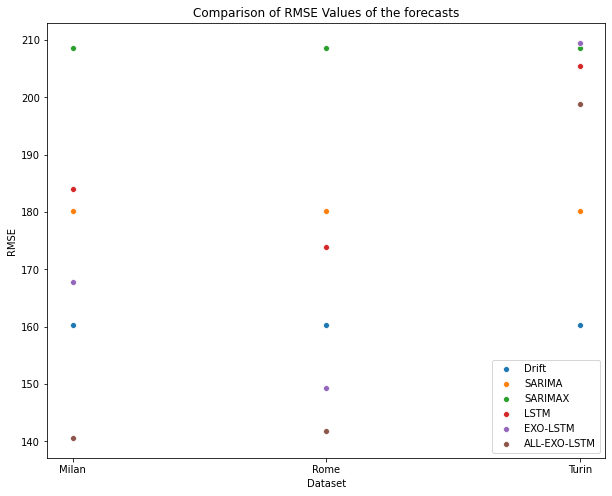

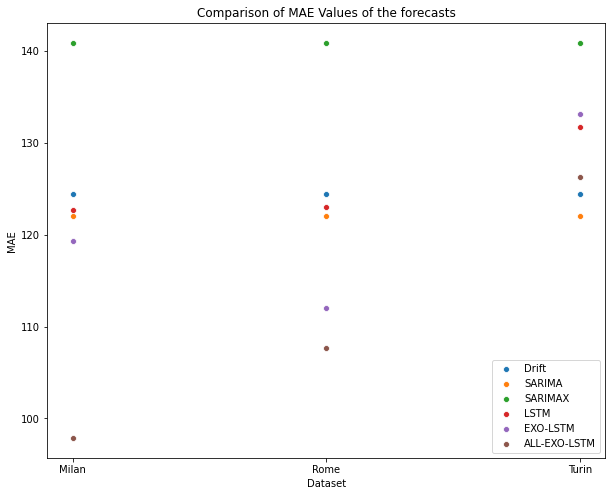

In [82]:
# Graphic comparison of error values: RMSE
plt.figure(figsize=(10,8))
plt.title("Comparison of RMSE Values of the forecasts")
ax = sns.scatterplot(x=mean_results.index, y="DRIFT RMSE", data=mean_results, label="Drift")
ax =sns.scatterplot(x=mean_results.index, y="ARIMA RMSE", data=mean_results, label="SARIMA")
ax = sns.scatterplot(x=mean_results.index, y="ARIMAX RMSE", data=mean_results, label="SARIMAX")
ax = sns.scatterplot(x=mean_results.index, y="LSTM RMSE", data=mean_results, label="LSTM")
ax = sns.scatterplot(x=mean_results.index, y="EXO-LSTM RMSE", data=mean_results, label="EXO-LSTM")
ax = sns.scatterplot(x=mean_results.index, y="ALL-EXO-LSTM RMSE", data=mean_results, label="ALL-EXO-LSTM")
ax.set(ylabel="RMSE")
plt.show()

# Graphic comparison of error values: MAE
plt.figure(figsize=(10,8))
plt.title("Comparison of MAE Values of the forecasts")
aax = sns.scatterplot(x=mean_results.index, y="DRIFT MAE", data=mean_results, label="Drift")
aax = sns.scatterplot(x=mean_results.index, y="ARIMA MAE", data=mean_results, label="SARIMA")
aax = sns.scatterplot(x=mean_results.index, y="ARIMAX MAE", data=mean_results, label="SARIMAX")
aax = sns.scatterplot(x=mean_results.index, y="LSTM MAE", data=mean_results, label="LSTM")
aax = sns.scatterplot(x=mean_results.index, y="EXO-LSTM MAE", data=mean_results, label="EXO-LSTM")
aax = sns.scatterplot(x=mean_results.index, y="ALL-EXO-LSTM MAE", data=mean_results, label="ALL-EXO-LSTM")
aax.set(ylabel="MAE")
plt.show()